## ***SACHAROMYCES CEREVISIAE*** OPTIMIZATION OUTPUT DATA PROCESSING

Since we've runned 10 Gene Over/Under expression optimization problem we've quite a lot of results to carefully interpret. We'll be using pandas (a powerful python library to handle data science preprocessing stages). <br> First we'll merge all 10 .csv file into 1 .csv file to better understand our data and preform various preprocessing steps to gather only the best solutions possible for our problem.

In [2]:
import os
import glob
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

# pandas has a set_option method that let you costumize the behaviour and display of dataframes
# here the set_option method is set to display the full contents of our dataframe
# pd.set_option("display.max_rows", None)
# pd.options.display.max_rows = 15

# setting the path to join multiple files 
files = os.path.join(r'C:\Users\geral\Desktop\BIOINF_PROJECT\2-PEopt\src\outputGOU', "*.csv")

# return a list of the merged files
files = glob.glob(files)

# using pandas methods concat and read_csv to join files
df = pd.concat([pd.read_csv(f, sep=";", index_col=False) for f in files], ignore_index=True)
print(f"This dataframe has: {df.shape[0] - 1} solutions and {df.shape[1]} columns.")

# pandas dataframe manipulation to drop unnecessary columns (columns only with NaN values)
df.drop(["Unnamed: 3", "solution"], axis=1, inplace=True)
print(f"This dataframe has: {df.shape[0] - 1} solutions and {df.shape[1]} columns after manipulation.")

# change column names
df.rename(columns={"Unnamed: 4": "Gene solutions", "Unnamed: 6": "Reaction constraints"}, inplace=True)


This dataframe has: 188 solutions and 7 columns.
This dataframe has: 188 solutions and 5 columns after manipulation.


In [3]:
df

,BPCY (r_4041 * r_1589),TargetFlux r_4041 with at least 0.0 of biomass (None),WYIELD biomass: r_4041 product: r_1589,Gene solutions,Reaction constraints
0,0.000000,0.000000,0.000000,"{'YBR166C': 0.25, 'YNL220W': 0.125, 'YIL043C':...","{'r_0714': 0, 'r_0020': (2.6153065645050235, 1..."
1,0.000000,0.000000,0.000000,"{'YBR166C': 0.25, 'YNL220W': 0.125, 'YGL063W':...","{'r_0714': 0, 'r_0020': (2.6153065645050084, 1..."
2,0.000000,0.000000,0.000000,"{'YDR305C': 0.5, 'YGR208W': 0.25, 'YOL126C': 0...","{'r_1025': (0, 0), 'r_0714': 0, 'r_0138': (0.0..."
3,0.000000,0.000000,0.000000,"{'YDR305C': 0.5, 'YNL241C': 4, 'YGR208W': 0.25...","{'r_1025': (0, 0), 'r_0714': 0, 'r_0138': (0.0..."
4,0.000000,0.000000,0.000000,"{'YDR305C': 0.5, 'YNL241C': 4, 'YGR208W': 0.25...","{'r_1025': (0, 0), 'r_0714': 0, 'r_0138': (0.0..."
...,...,...,...,...,...
184,0.650626,0.598086,0.351609,"{'YMR267W': 2, 'YLR308W': 2, 'YNL331C': 0.25, ...","{'r_1069': 0, 'r_0468': (0, 0), 'r_1109': (0, ..."
185,0.249412,0.094355,1.269405,"{'YJR103W': 16, 'YJL121C': 4, 'YFL058W': 0.125...","{'r_0279': (2.644694430440478, 10000), 'r_0307..."
186,0.090259,0.094355,1.319482,"{'YPL262W': 2, 'YGR193C': 0.125, 'YJL121C': 2,...","{'r_0279': (2.6446944304404685, 10000), 'r_045..."
187,0.054513,0.094355,1.265827,"{'YPL262W': 2, 'YNL191W': 0, 'YGL148W': 4, 'YF...","{'r_4171': (0, 0), 'r_0279': (1.32234721522023..."


Our first preprocessing step will be ignoring all modifications that have biomass of less than 0.1. We can obtain the biomass values by dividing the values on the BPCY column with the flux of 2-phenylethanol. This flux can be obtained using MEWpy get_simulator function.

In [4]:
from cobra.io import read_sbml_model
from mewpy.simulation import get_simulator

model = read_sbml_model("models/yeast-GEM.xml")

O2 = "r_1992" # EX_o2_e (r_1992)
GLC = "r_1714" # EX_glc__D_e (r_1714)

envcond = {
        O2: (-20.0, 100000.0), 
        GLC: (-10.0, 100000.0)
        }

BIOMASS_ID = "r_4041" # BIOMASS_yeast-GEM (r_4041)
PRODUCT_ID = "r_1589" # EX_2phetoh_e (r_1589)

simul = get_simulator(model, envcond=envcond)
phenyl_FVA = simul.FVA(reactions = [PRODUCT_ID]) # {'r_1589': [0.0, 0.9275619609710613]}

phenyl_FLUX = 0
for key, value in phenyl_FVA.items():
        phenyl_FLUX += value[1]

print(phenyl_FVA)


{'r_1589': [0.0, 0.9275619609710613]}


In [46]:
simul.FVA(reactions = [PRODUCT_ID], format="df") # {'r_1589': [0.0, 0.9275619609710613]}

,Reaction ID,Minimum,Maximum
0,r_1589,0.0,0.927562


In [5]:
# Create new column with biomass values by dividing BPCY values with 2-phenylethanol flux
df["Biomass"] = df["BPCY (r_4041 * r_1589)"] / phenyl_FLUX

# Drop rows that have a biomass value of less than 0.1
df.drop(df[df["Biomass"] < 0.1].index, inplace=True)

print(f"This dataframe has {df.shape[0] - 1} solutions after deleting all rows with biomass inferior to 0.1.")
df.reset_index(drop=True, inplace=True)

This dataframe has 114 solutions after deleting all rows with biomass inferior to 0.1.


Our goal now is to reduce even more our pool of possible solutions by choosing the ones that have less genetic modifications. <br>
To make this analysis we need to make some changes to our dataframe first. Although our "Gene solutions" and "Reaction constraints" column values look like a dictionary they're actually strings formatted as dictionaries. To make these changes we will use **ast**, a python library that makes transforming a dictionary formatted string into a python dictionary object possible.

In [6]:
import ast

df["Reaction constraints"] = df["Reaction constraints"].apply(ast.literal_eval)
df["Gene solutions"] = df["Gene solutions"].apply(ast.literal_eval)


In [7]:
df.drop(df[df["Gene solutions"].map(len) > 15].index, inplace=True)
df.reset_index(drop=True, inplace=True)

df.shape[0] - 1

70

With our pool of possible solutions we want to narrow it down to the ones that have a FVA minimum value higher than 0. We can use MEWpy to calculate these values.

In [8]:
from mewpy.simulation import get_simulator

simulator = get_simulator(model, envcond=envcond)
lista_reaction_constraints = [a for a in df["Reaction constraints"]]

for index, constraint in enumerate(lista_reaction_constraints):
    try:
        a = simulator.FVA(constraints=constraint, reactions = [PRODUCT_ID])
        if a.get("r_1589")[0] == 0:
            df.drop(index, inplace=True)
    except Exception:
        pass

df.drop(3, inplace=True)
df.reset_index(drop=True, inplace=True)

In [9]:
df

,BPCY (r_4041 * r_1589),TargetFlux r_4041 with at least 0.0 of biomass (None),WYIELD biomass: r_4041 product: r_1589,Gene solutions,Reaction constraints,Biomass
0,0.398820,0.102054,3.550329,"{'YPL028W': 0, 'YNL316C': 32, 'YMR105C': 8, 'Y...","{'r_0104': 0, 'r_0103': 0, 'r_0439': (0, 18.98...",0.429966
1,0.311934,0.077422,3.702119,"{'YGR256W': 2, 'YDL198C': 0.0625, 'YLR359W': 0...","{'r_0151': (0, 0.08376934531786118), 'r_0152':...",0.336295
2,0.475955,0.118863,3.611968,"{'YGR256W': 2, 'YNL316C': 32, 'Q0045': 0.25}","{'r_0438': (0, 19.307971581669968), 'r_0889': ...",0.513125
3,0.439335,0.110119,3.613078,"{'YGR256W': 2, 'YNL316C': 32, 'Q0045': 0.25, '...","{'r_1056': (0, 0), 'r_1063': 0, 'r_4226': 0, '...",0.473645
4,0.477147,0.119819,3.588457,"{'YGR256W': 2, 'YNL316C': 32, 'Q0045': 0.25, '...","{'r_0851': 0, 'r_1056': (0, 0), 'r_1063': 0, '...",0.514409


Of the remaining possible solutions we want to select the ones that have the least UP-REGULATED genes since it's more easy to implement a DOWN-REGULATION or a DELETION of a gene than a UP-REGULATION. We want to see on what the five solutions consists of.

In [10]:
for index, modification in enumerate(df["Gene solutions"]):
    print(f"modification {index}")
    print("*****************************")
    for key, value in modification.items():
        if value > 1:
            print(key, value, "     UPREGULATION")
        elif value == 0:
            print(key, value, "     DELETION")
        else:
            print(key, value, "     DOWNREGULATION")

modification 0
*****************************
YPL028W 0      DELETION
YNL316C 32      UPREGULATION
YMR105C 8      UPREGULATION
YHR183W 4      UPREGULATION
YOR065W 0.5      DOWNREGULATION
modification 1
*****************************
YGR256W 2      UPREGULATION
YDL198C 0.0625      DOWNREGULATION
YLR359W 0.5      DOWNREGULATION
YCL050C 2      UPREGULATION
YDR497C 0.25      DOWNREGULATION
YNL316C 32      UPREGULATION
Q0045 0.25      DOWNREGULATION
YPR145W 16      UPREGULATION
modification 2
*****************************
YGR256W 2      UPREGULATION
YNL316C 32      UPREGULATION
Q0045 0.25      DOWNREGULATION
modification 3
*****************************
YGR256W 2      UPREGULATION
YNL316C 32      UPREGULATION
Q0045 0.25      DOWNREGULATION
YDR111C 0      DELETION
YGL202W 0      DELETION
YPR145W 4      UPREGULATION
modification 4
*****************************
YGR256W 2      UPREGULATION
YNL316C 32      UPREGULATION
Q0045 0.25      DOWNREGULATION
YDR111C 0      DELETION
YGL202W 0      DELETION
Y

For our 5 possible solutions we can now calculate how they will perform in our organism by simulating an FVA with these solutions as constraints.

In [14]:
lista_reaction_constraints = [a for a in df["Reaction constraints"]]

for constraint in lista_reaction_constraints:
    try:
        print(simulator.FVA(constraints=constraint, reactions = [PRODUCT_ID]))
    except:
        pass

{'r_1589': [0.7647641916012162, 3.9424708441018765]}
{'r_1589': [1.5654445497925735, 4.002905514982444]}
{'r_1589': [0.3316598765143226, 4.0737335858865436]}
{'r_1589': [0.5747751433784742, 4.0407779307601]}
{'r_1589': [0.27281669272565523, 4.055190315120399]}


We can even simulate the flux rate of our target (in this case the reaction "r_1589", 2-phenylethanol exchange), using our environmental conditions and the constraints suggested by our solutions.

In [15]:
from mewpy.problems import GOUProblem

problem = GOUProblem(model, [], envcond=envcond)
sim = problem.simulator

for index, constraint in enumerate(lista_reaction_constraints):
    print(f"solution {index}")
    print(sim.simulate(constraints=constraint).find('r_1589'))

solution 0
  Reaction ID  Flux rate
0      r_1589   3.753913
solution 1
  Reaction ID  Flux rate
0      r_1589   3.858282
solution 2
  Reaction ID  Flux rate
0      r_1589   3.851711
solution 3
  Reaction ID  Flux rate
0      r_1589   3.835133
solution 4
  Reaction ID  Flux rate
0      r_1589   3.830782


The envelope production plots let us see how our model behaves by computing the minimal and maximal phenylethanol production rates at different rates of biomass production.
As mentioned in the article written for this project we will mainly focus in two of the five possible solutions with them being solution 1 and solution 4.

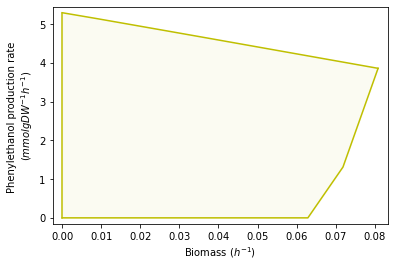

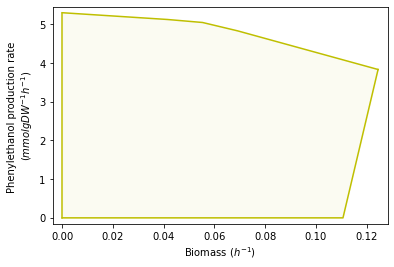

In [42]:
from mewpy.visualization.envelope import plot_flux_envelope
import matplotlib.pyplot as plt 

LABEL_X = r"Biomass ($h^{-1}$)"
LABEL_Y = "Phenylethanol production rate \n" + r"($mmol gDW^{-1} h^{-1}$)"

#solution 1
plot_flux_envelope(sim,BIOMASS_ID,PRODUCT_ID,constraints = lista_reaction_constraints[1], label_x= LABEL_X, label_y=LABEL_Y, plot_kwargs={"color":"y"}, fill_kwargs = {'color': 'y', 'alpha': 0.05})
#solution 4
plot_flux_envelope(sim,BIOMASS_ID,PRODUCT_ID,constraints = lista_reaction_constraints[4], label_x= LABEL_X, label_y=LABEL_Y, plot_kwargs={"color":"y"}, fill_kwargs = {'color': 'y', 'alpha': 0.05})

Wild-type *Saccharomyces cerevisiae* flux envelope

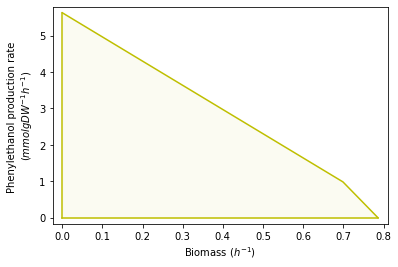

In [43]:
plot_flux_envelope(sim,BIOMASS_ID,PRODUCT_ID, label_x= LABEL_X, label_y=LABEL_Y, plot_kwargs={"color":"y"}, fill_kwargs = {'color': 'y', 'alpha': 0.05})